In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.6 MB/s eta 0:00:00


**Imports and global settings**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

# EDA

**Reading in the dataset**

In [3]:
data = pd.read_csv("/content/Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**Any duplicate rows?**

In [4]:
n_dup = len(data) - len(data.drop_duplicates())
print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [5]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

**Checking data types**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**Cleaning up column names (mainly for handling purposes)**

In [7]:
cols_cleaned = []

for col in data.columns:
    cols_cleaned.append(col.strip().lower())

data.columns = cols_cleaned

# sanity check
data.head()

,customerid,gender,age,annual income (k$),spending score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


drop the "id" column because it's irrelevant

In [8]:
df = data.drop(columns=["customerid"])
df.head()

,gender,age,annual income (k$),spending score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


transform the gender column to numeric and show the results

In [9]:
gender_mapping = {'Male': 0, 'Female': 1} # Define the mapping
df['gender_numeric'] = df['gender'].map(gender_mapping)
df.drop(columns=['gender'], inplace=True)

In [10]:
df.head()

,age,annual income (k$),spending score (1-100),gender_numeric
0,19,15,39,0
1,21,15,81,0
2,20,16,6,1
3,23,16,77,1
4,31,17,40,1


**Quick overview over the individual distributions**

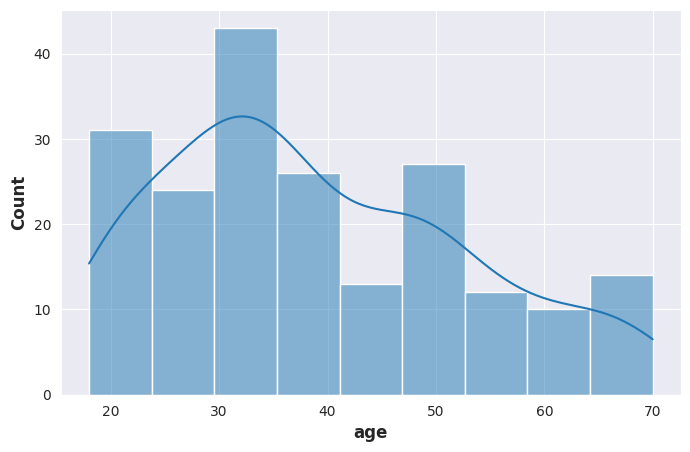

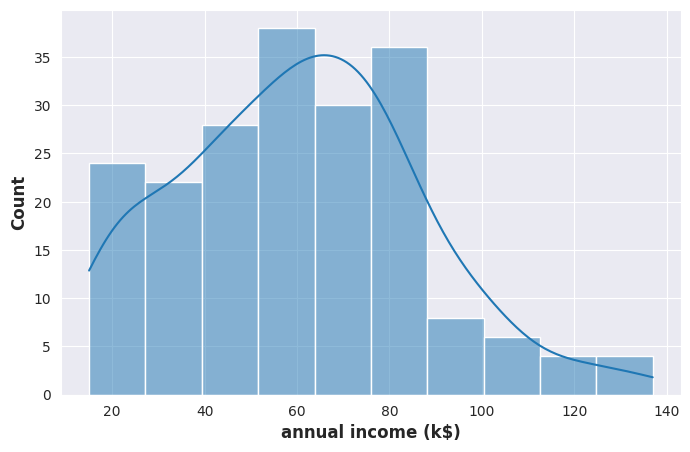

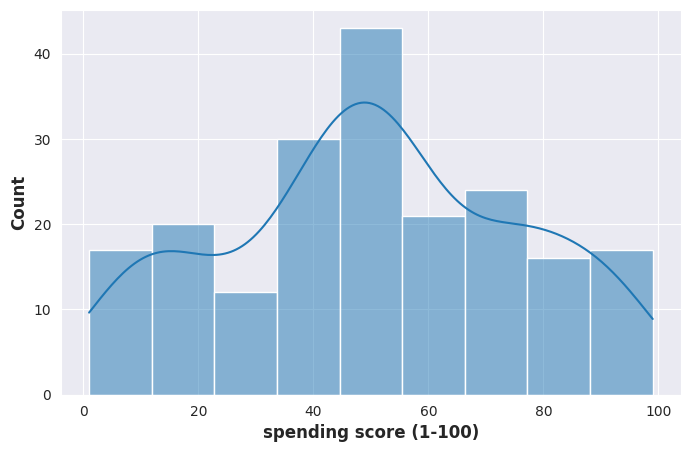

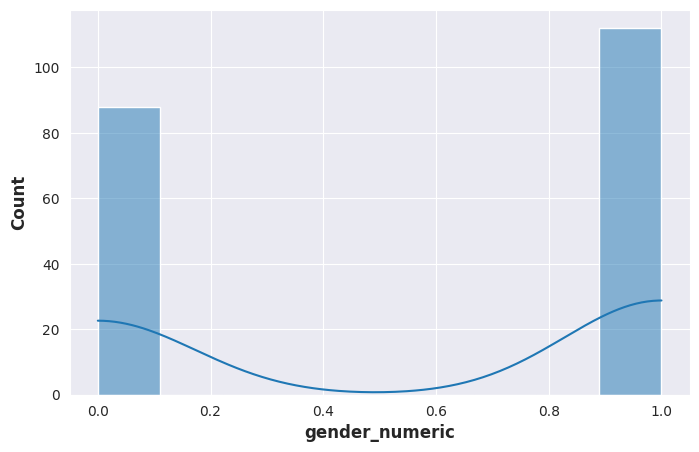

In [11]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

==> Distributions require scaling and standardization.

# Clustering

In [12]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [13]:
X = StandardScaler().fit_transform(df)

In [14]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [15]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,age,annual income (k$),spending score (1-100),gender_numeric
0,-1.757028,-1.917665,-0.432056,-0.893143
1,-1.554328,-1.917665,1.213469,-0.893143
2,-1.655054,-1.872655,-1.683247,1.087358
3,-1.356711,-1.872655,1.054274,1.087358
4,-0.621479,-1.827750,-0.393679,1.087358


## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 4 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [16]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

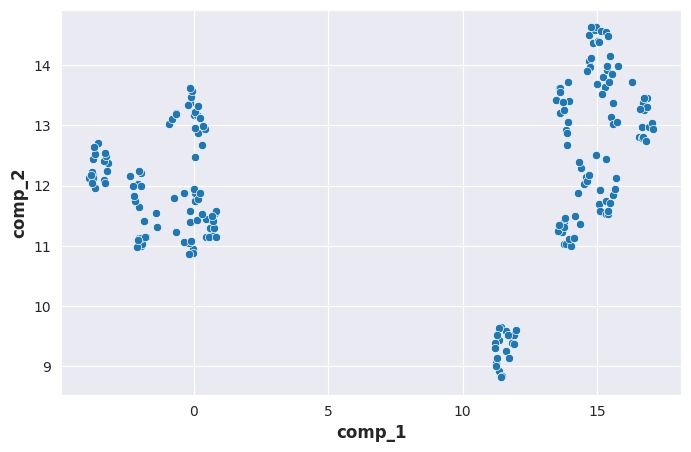

In [17]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

==> The structure of this dataset is fairly straight-forward. One would expect a clustering algo to find 3 clusters here.

## Definition of plotting and convergence check function

In [18]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(((len(df) - sum(np.where(labels_all == -1, False, True))) / len(df)) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [19]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [20]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

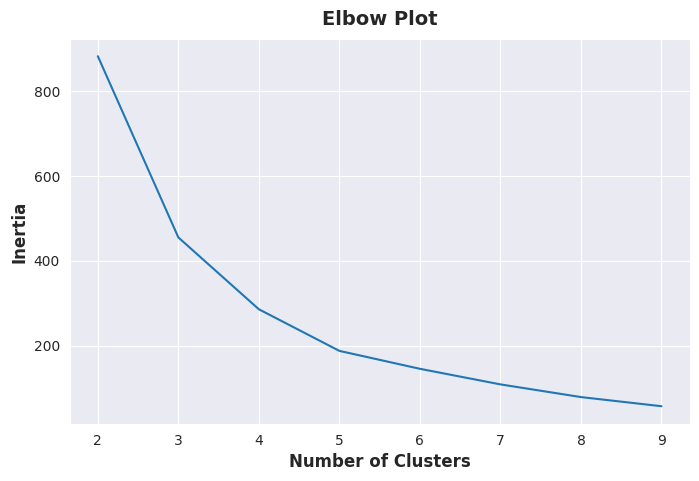

In [21]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

==> Salient "kink" at 3 clusters. This is thus the number of clusters to go for. As discussed above, this is along the lines of what is to be expected by just looking at the data.

### Run with optimised *n_clusters*

In [22]:
%%time

start_time = time.time()

kmeans = KMeans(n_clusters=3, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 6, max_iter: 300

CPU times: user 41.2 ms, sys: 0 ns, total: 41.2 ms
Wall time: 35.1 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


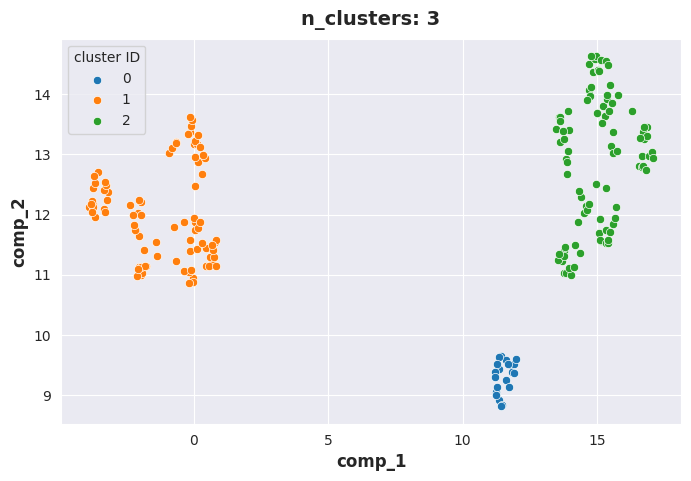

In [23]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=3, noise_exist=False)

==> Those results seem very reasonable. This is not unexpectd as the structure of the data is such that it does not collide with the fundamental assumptions of K-means, namely that the clusters form **non-overlapping (hyper)spheres** (i.e. "circles" in 2D) of **roughly the same extent** (and the dataset is does not contain an "excessive" number of outliers).

## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [24]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [25]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 6, max_iter: 300

CPU times: user 253 ms, sys: 91.9 ms, total: 345 ms
Wall time: 3.58 s


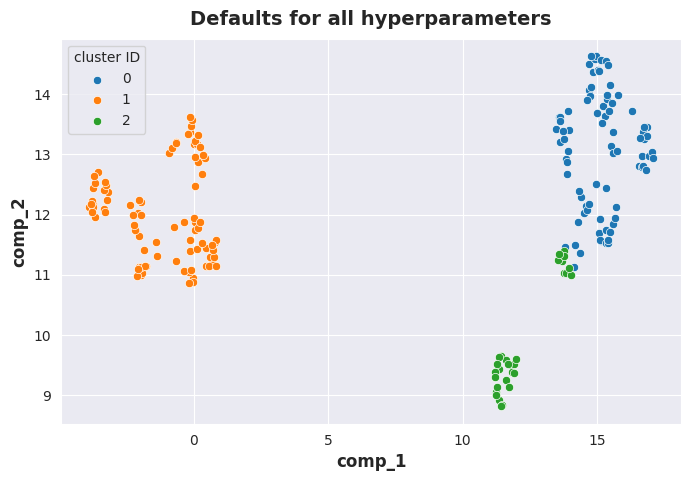

In [26]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The estimation for *bandwidth* seems to work well here. There is thus no need for any further tuning of this hyperparameter.

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [27]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 6, max_iter: 300

CPU times: user 254 ms, sys: 8.2 ms, total: 262 ms
Wall time: 1.33 s


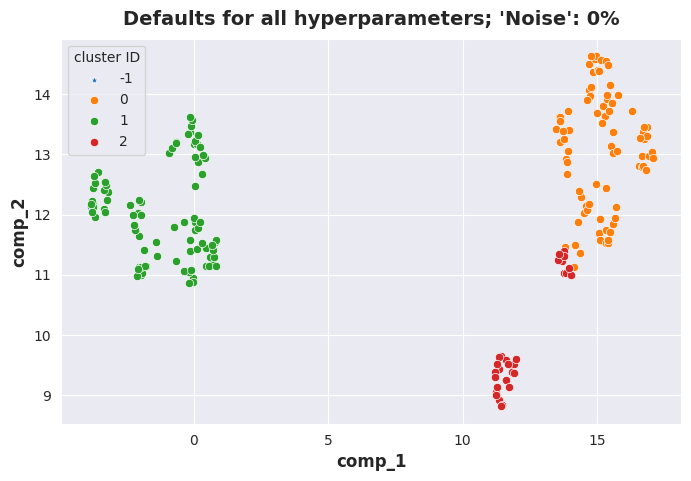

In [28]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Data points that the algorithm identifies as "not being part of any cluster" (i.e. 'noise' or 'orphans') are marked as blue stars (cluster ID: -1).

==> Results look sensible but not substantially different to the solution for the default *cluster_all=True* for this dataset.

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [29]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [30]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 3, max_iter: 100

CPU times: user 35.2 ms, sys: 10.9 ms, total: 46.1 ms
Wall time: 89.4 ms


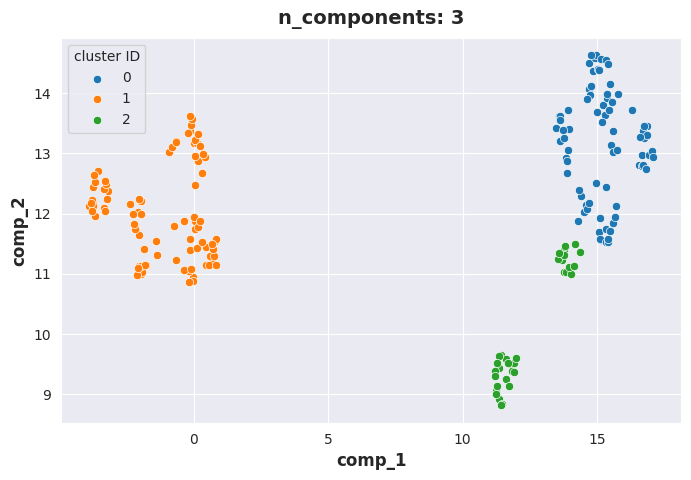

In [31]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

==> The results look quite reasonable. This is, again, not completely unexpected as the structure of the data does form more of less **elliptic "blobs"** in 2D, which is what the Gaussian mixture model is quite good at capturing.

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [32]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [33]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)


CPU times: user 216 ms, sys: 2.04 ms, total: 218 ms
Wall time: 574 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


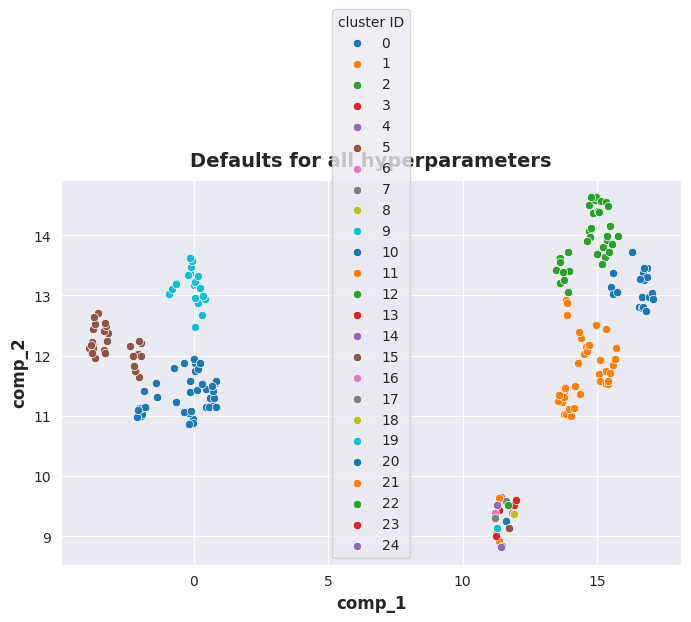

In [34]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

==> The vanilla algo finds a lot more clusters than the 3 that were expected. There is a possibility, however, that those "additional" clusters actually represent something that could be of interest here, but this is beyond the scope of this exercise.

### Tuning runs for "damping"

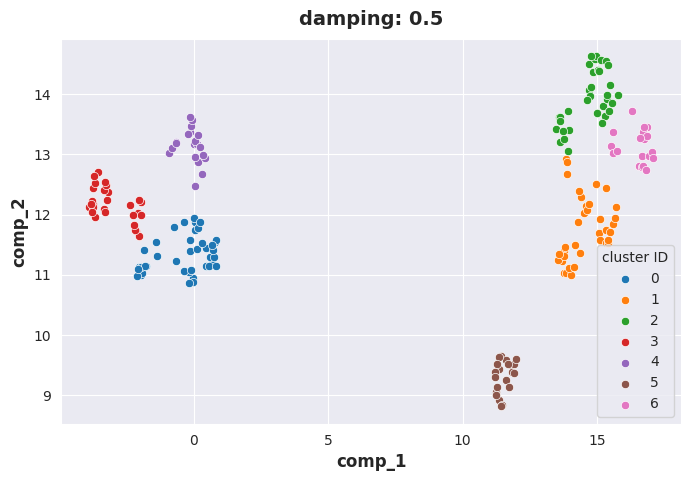

Algorithm converged successfully!
n_iter: 221, max_iter: 500



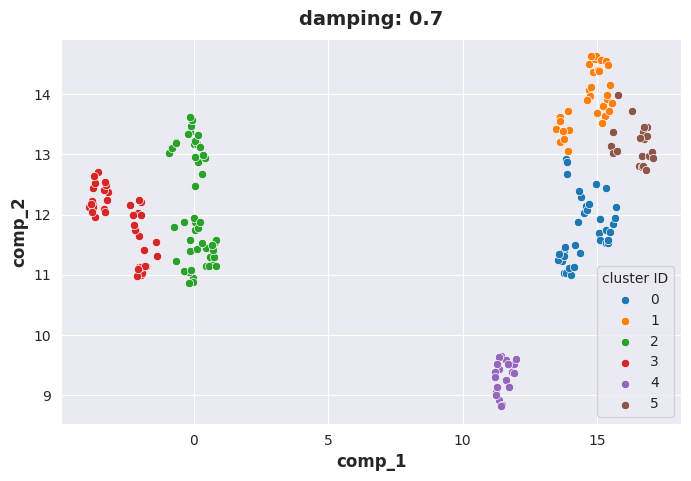

Algorithm converged successfully!
n_iter: 26, max_iter: 500



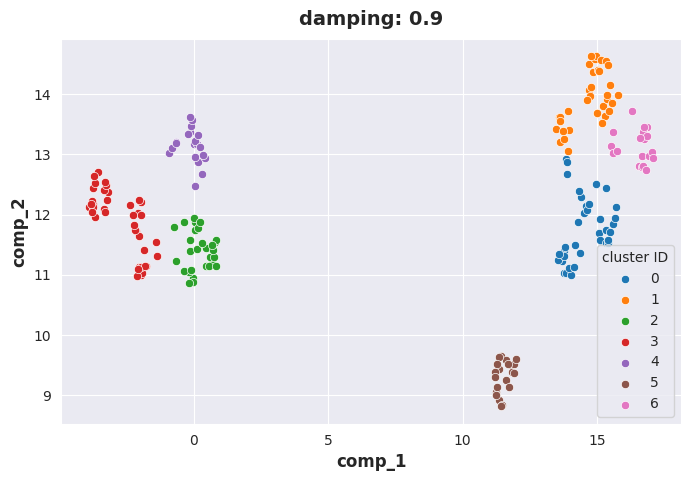

Algorithm converged successfully!
n_iter: 47, max_iter: 500



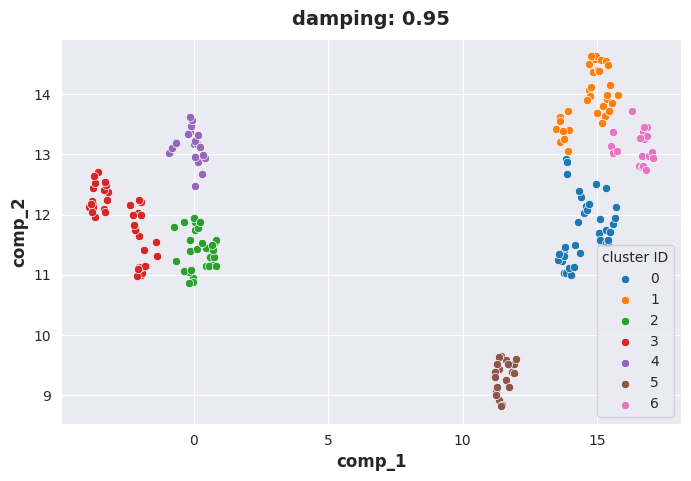

Algorithm converged successfully!
n_iter: 80, max_iter: 500



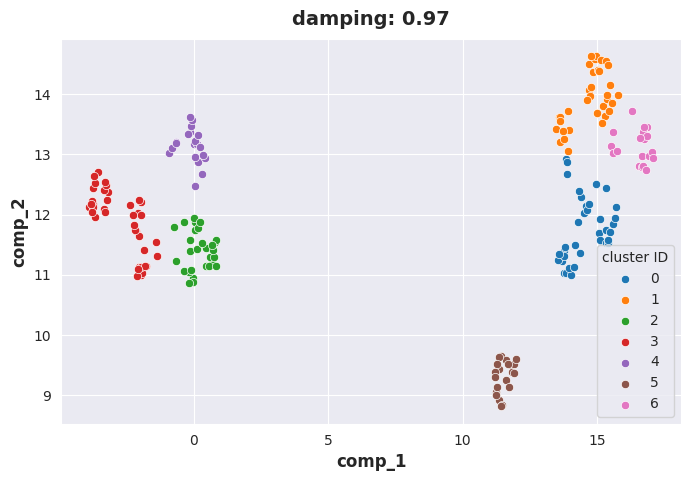

Algorithm converged successfully!
n_iter: 126, max_iter: 500



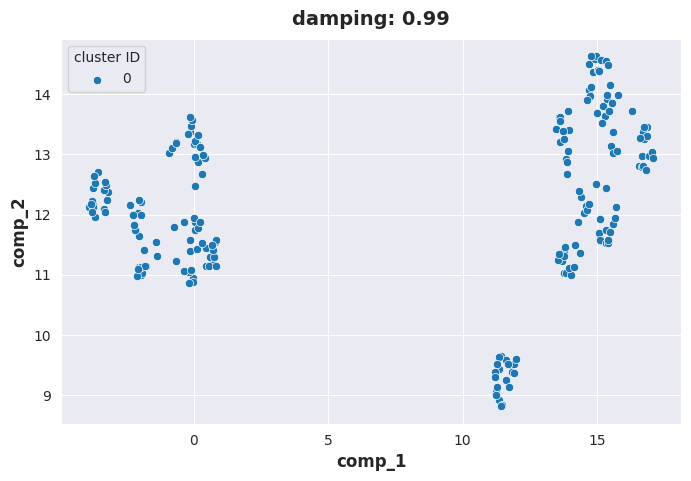

Algorithm converged successfully!
n_iter: 272, max_iter: 500

CPU times: user 5.62 s, sys: 264 ms, total: 5.88 s
Wall time: 7.71 s


In [35]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

==> Tuning "damping" does not seem to be very "effective" for this dataset!

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [36]:
# hyperparamter to tune

affprop_hparam = "preference"

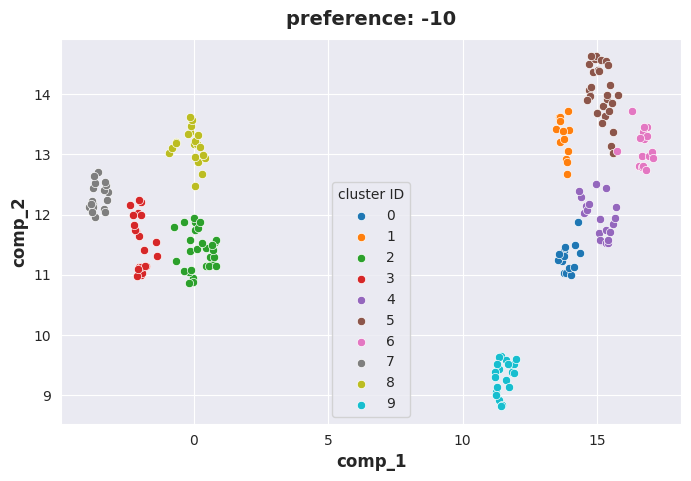

Algorithm converged successfully!
n_iter: 99, max_iter: 500



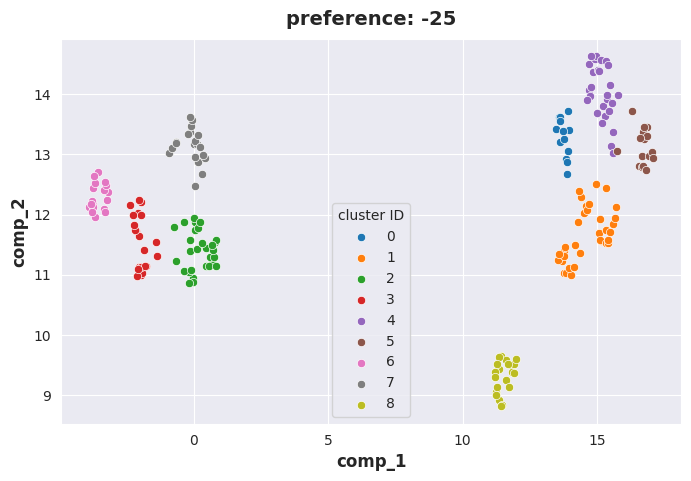

Algorithm converged successfully!
n_iter: 137, max_iter: 500



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


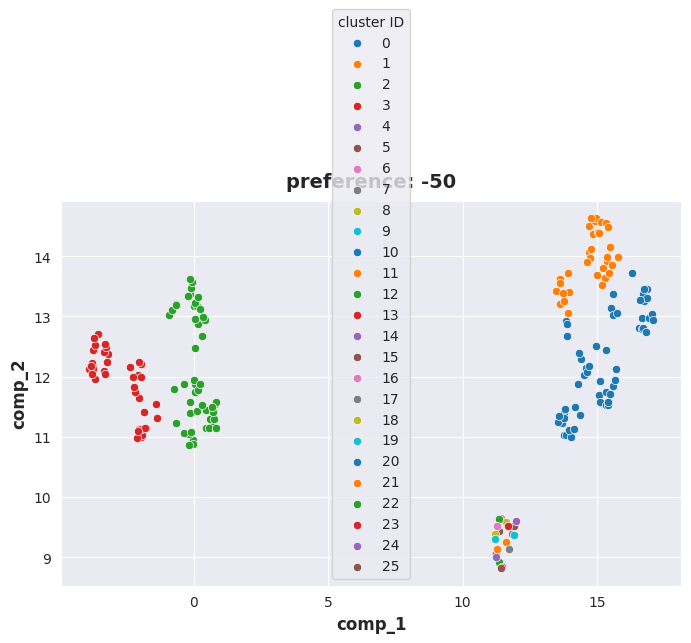

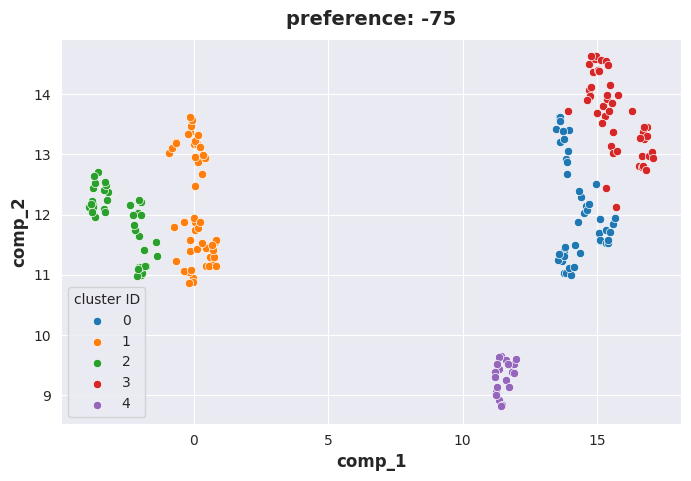

Algorithm converged successfully!
n_iter: 306, max_iter: 500



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


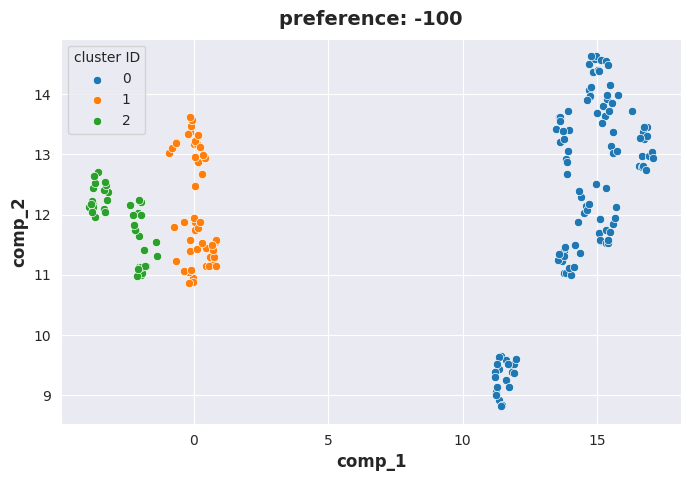


CPU times: user 5.52 s, sys: 434 ms, total: 5.95 s
Wall time: 7.15 s


In [37]:
%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

==> In contrast to *damping*, *preference* seems to have a much stronger influcence on the number of formed clusters ***for this particular dataset***.

### Re-run with optimised *preference*

In [38]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)


CPU times: user 279 ms, sys: 67 µs, total: 279 ms
Wall time: 280 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [39]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

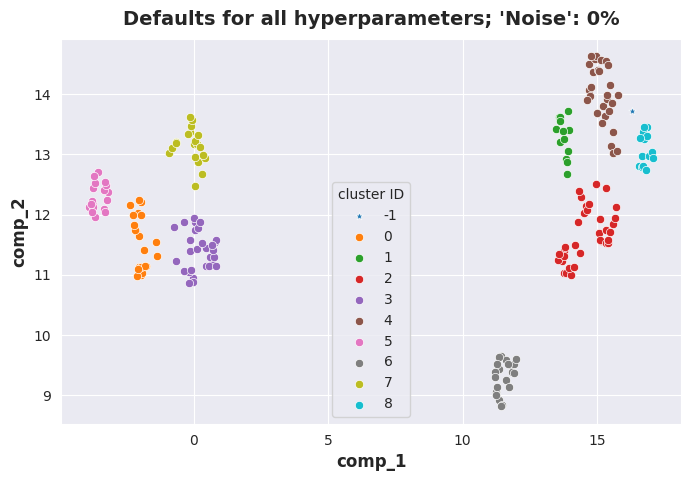

CPU times: user 748 ms, sys: 109 ms, total: 856 ms
Wall time: 753 ms


In [40]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The result looks quite convincing! It is important to note here that the structure of data is not at odds with what DBSCAN requires in order to work satisfactorily, i.e. that the **clusters are of a roughly similar density**. Approximately 4% off all datapoints were identified as noise here.

### Tuning runs for *eps*

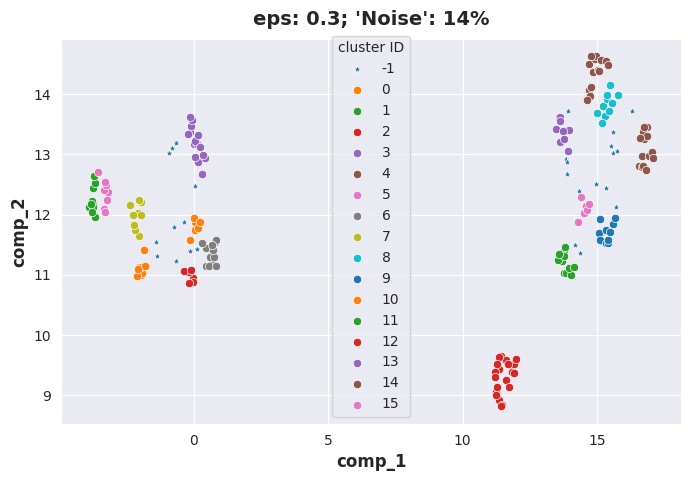

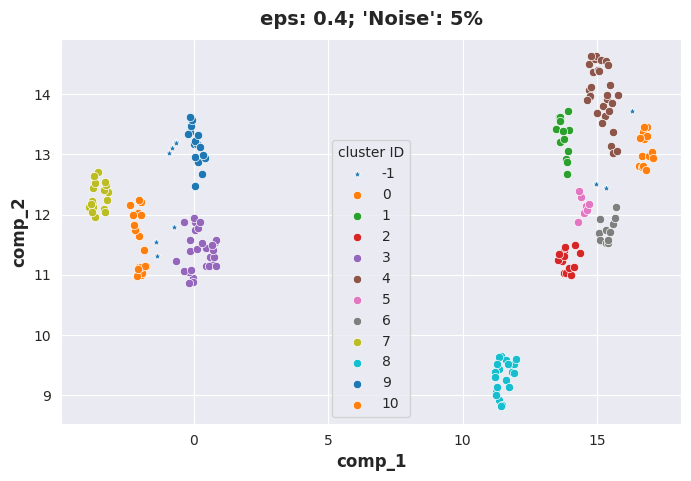

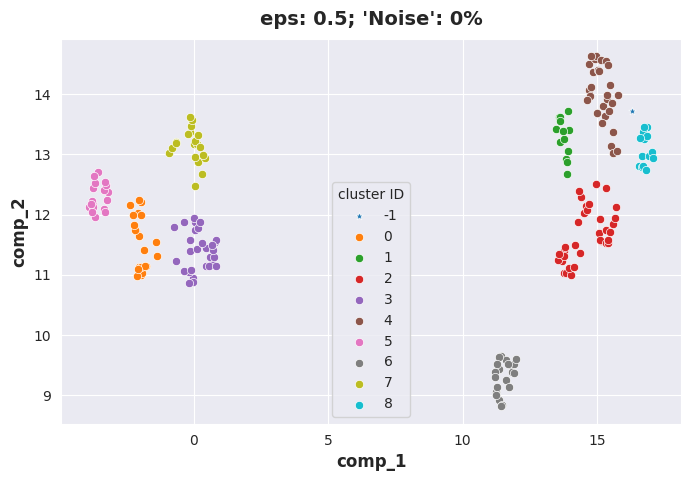

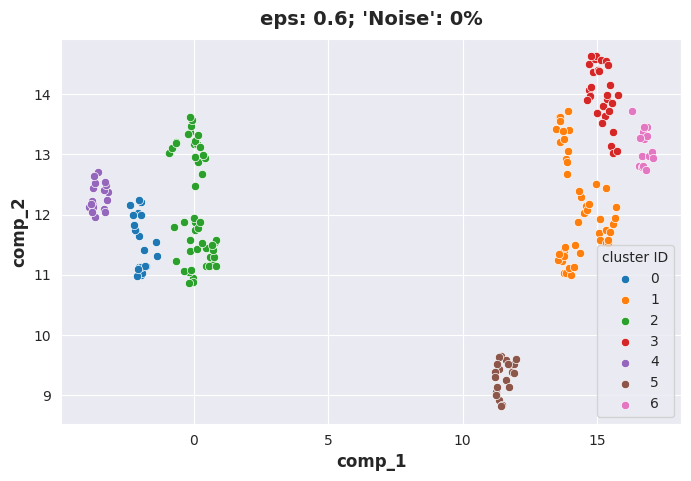

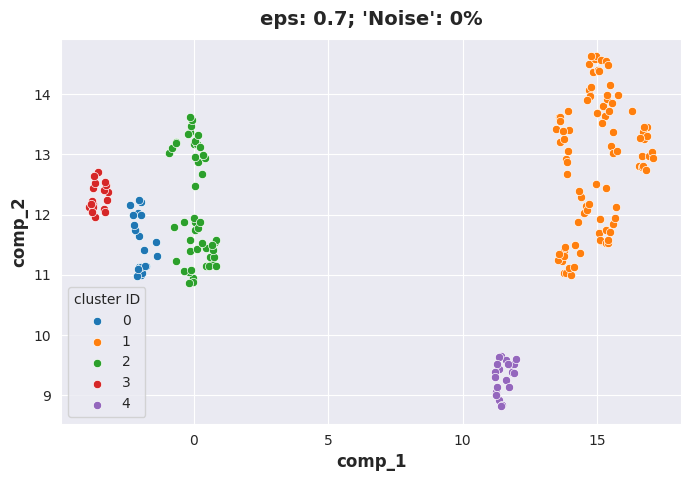

CPU times: user 4.07 s, sys: 550 ms, total: 4.62 s
Wall time: 4.17 s


In [41]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

==> The algorithm shows quite a high sensitivity to ***eps***. A value of around 0.6 seems to work best for this particular dataset.

### Re-run with optimised *eps*

In [42]:
%%time

eps_val = 0.6

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 6.57 ms, sys: 2.85 ms, total: 9.42 ms
Wall time: 23.6 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [43]:
# hyperparamter to tune

optics_hparam = "min_samples"

### Vanilla run (defaults for all hyperparameters)

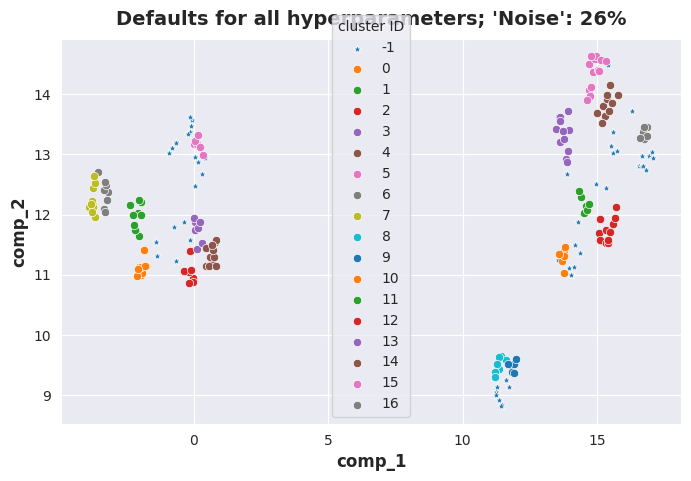

CPU times: user 2.21 s, sys: 207 ms, total: 2.41 s
Wall time: 4.37 s


In [44]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

==> The algorithm identified a considerable number of clusters. Furthermore, a substantial partion of the dataset is labelled as "noise".

### Tuning runs for *min_samples*

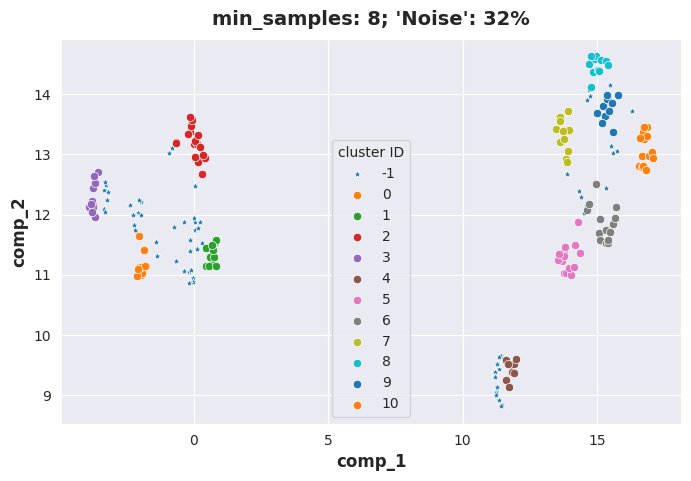

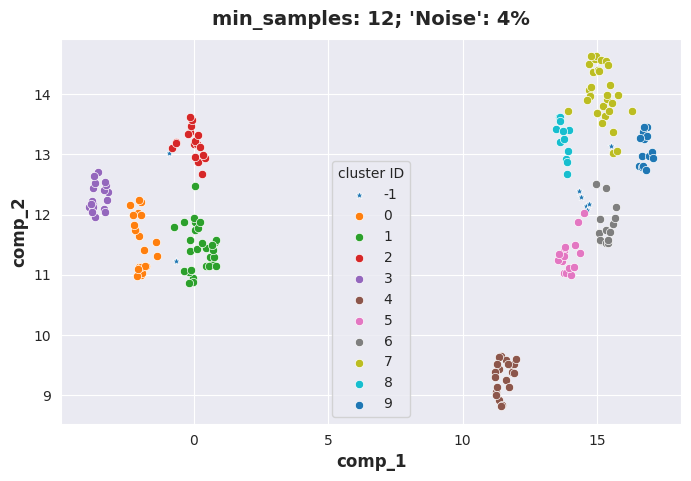

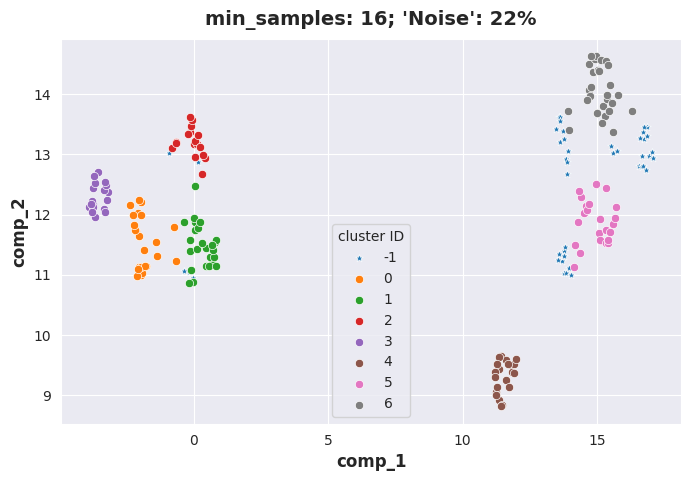

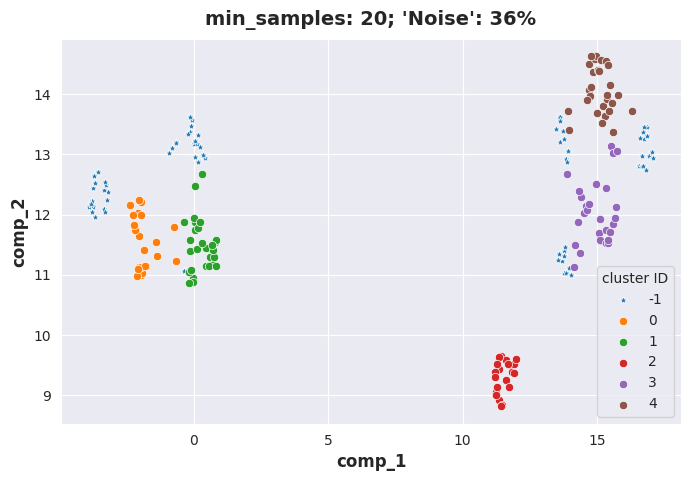

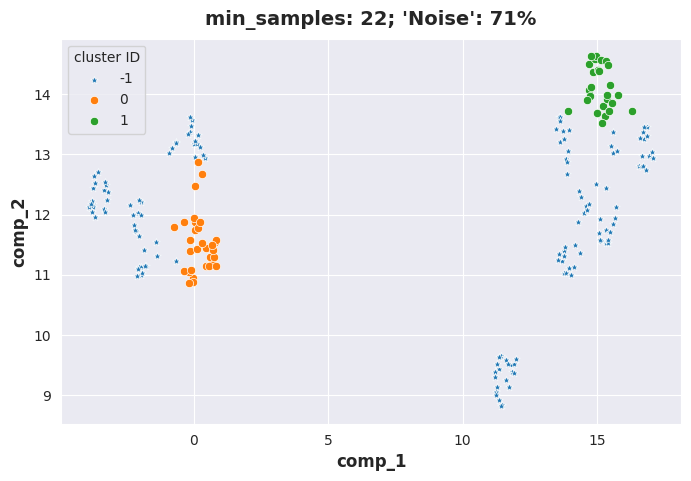

CPU times: user 6.36 s, sys: 1.43 s, total: 7.79 s
Wall time: 16.7 s


In [45]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

==> An approprate value for *min_samples* would be around 20.

### Re-run with optimised *min_samples*

In [46]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 664 ms, sys: 170 ms, total: 834 ms
Wall time: 2.71 s


# Comparison of training times

6
6


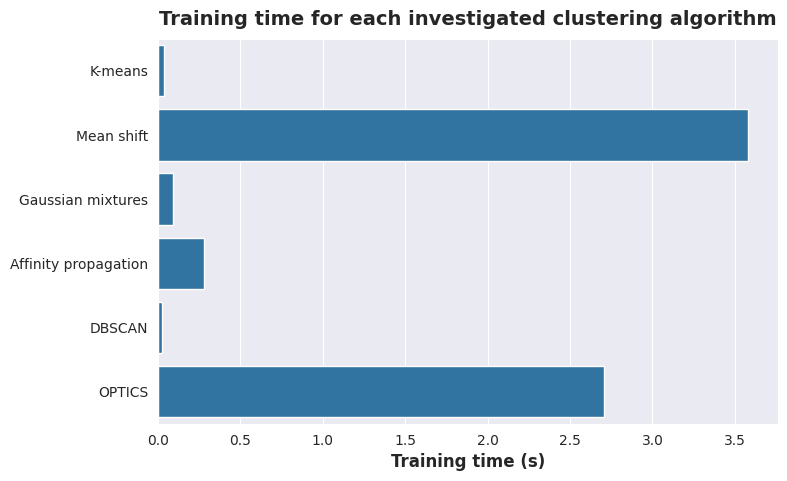

In [47]:
print(len(algos))
print(len(training_times))

# Ensure both lists have the same length before plotting
# For demonstration, I'm truncating the longer list,
# but you should adjust based on your specific needs.
min_length = min(len(algos), len(training_times))
algos = algos[:min_length]
training_times = training_times[:min_length]

plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

==> The training times across the investigated algorithms **vary considerably**! On the scale of the training times for the Mean shift and OPTICS algorithms, the training times of the other algos practically vanish. Interestingly enough though, when allowing for data points to be considered as "noise" for the Mean shift algo, its training time reduced substantially. For the following, its training time for *cluster_all=False* is taken as its relevant time. Furthermore, OPTICS is excluded so to allow for a comparison of the training times of the remaining algos on a more sensible scale.

In [48]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

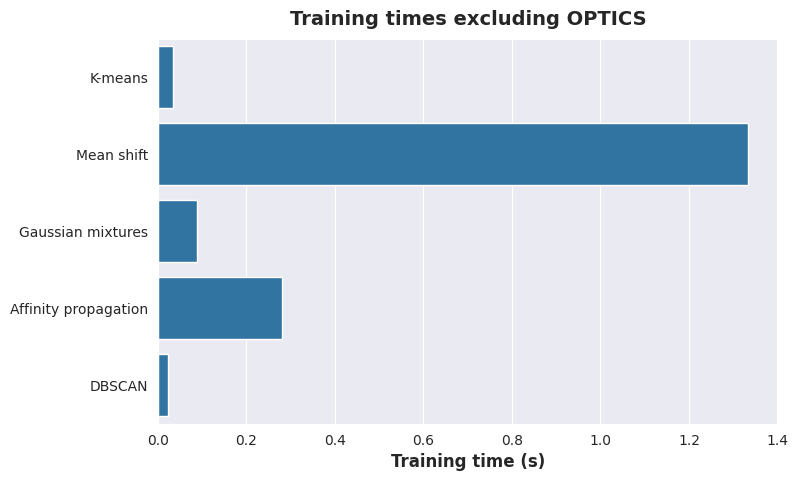

In [49]:
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()

# Conclusions

As with practically everything else in the machine learning domain, when it comes to clustering there is no "one-size-fits-all" algorithm. Different algorithms tend to be better depending on the structure of the data and in particluar **to what extent this structure is in line with what each algorithm relies on in order to work satisfactorily**. For the relatively simple data structure of the "wine dataset", practically all investigated algorithms performed well (after more or less hyperparameter turning).

Two important caveats regarding the results of this "study":
- Only the **single "most important" hyperparameter** was considered for tuning for each algorithm.
- The **dataset** employed here is **very small**. For datasets of a more real-world size, the relative performance in terms of training times will most likely be different.

In [50]:
from sklearn.decomposition import PCA

X_red_2 = PCA(n_components=2, random_state=fixed_random_state).fit_transform(X)

In [51]:
reducer_3 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_3 = reducer_3.fit_transform(X)

In [52]:
X_red_3 = pd.DataFrame(embedding_3, columns=["comp_1", "comp_2"])

# sanity check
X_red_3.head()

,comp_1,comp_2
0,15.947308,-6.890538
1,15.898786,-6.567707
2,10.558824,16.968554
3,12.576351,10.618251
4,10.566451,16.896255


In [53]:
reducer_1 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_1 = reducer_1.fit_transform(X)
reducer_2 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_2 = reducer_2.fit_transform(X_red_2)

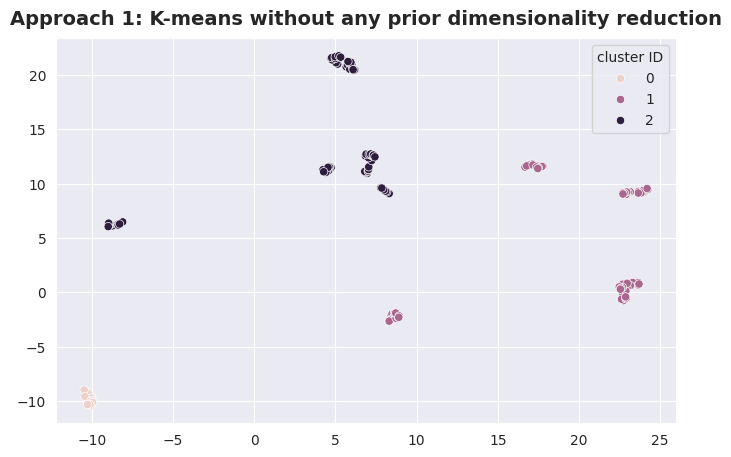

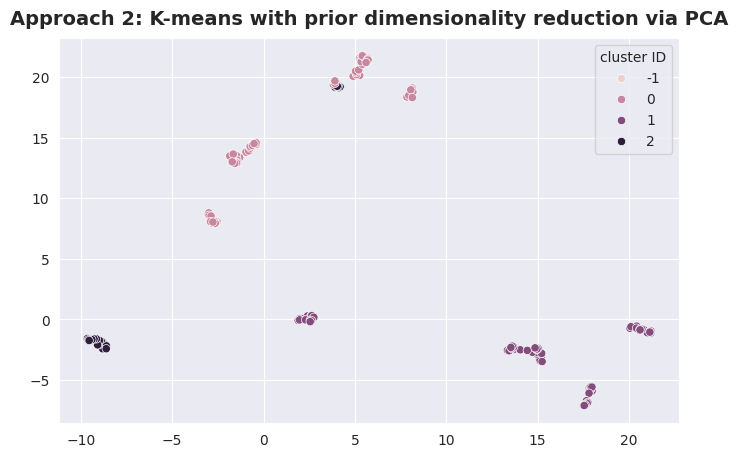

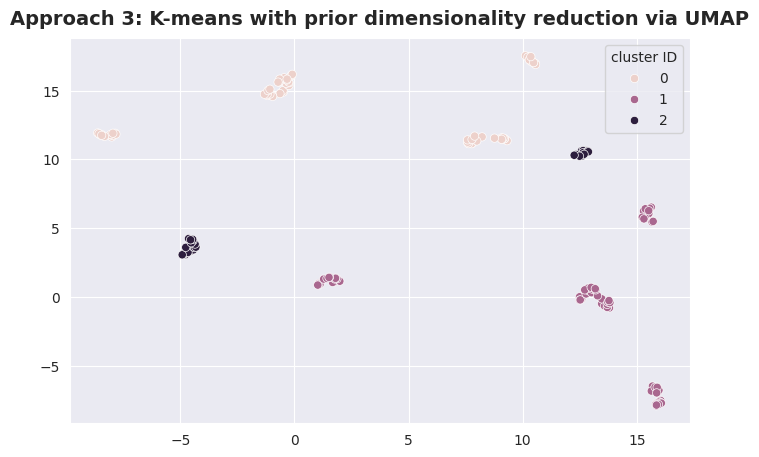

In [54]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_1[:, 0], y=embedding_1[:, 1], hue=labels_1)
plt.title("Approach 1: K-means without any prior dimensionality reduction")
plt.legend(title="cluster ID")
plt.show()

plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_2[:, 0], y=embedding_2[:, 1], hue=labels_2)
plt.title("Approach 2: K-means with prior dimensionality reduction via PCA")
plt.legend(title="cluster ID")
plt.show()

plt.figure(figsize=std_figure_size)
sns.scatterplot(data=X_red_3, x="comp_1", y="comp_2", hue=labels_3)
plt.title("Approach 3: K-means with prior dimensionality reduction via UMAP")
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title="cluster ID")
plt.show()

In [55]:
inertias_2 = []
range_clusters_2 = np.arange(2, 10, dtype=int)

for n in range_clusters_2:
    kmeans_2 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X_red_2)
    inertias_2.append(kmeans_2.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [56]:
inertias_3 = []
range_clusters_3 = np.arange(2, 10, dtype=int)

for n in range_clusters_3:
    kmeans_3 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X_red_3)
    inertias_3.append(kmeans_3.inertia_)

# inertias_3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

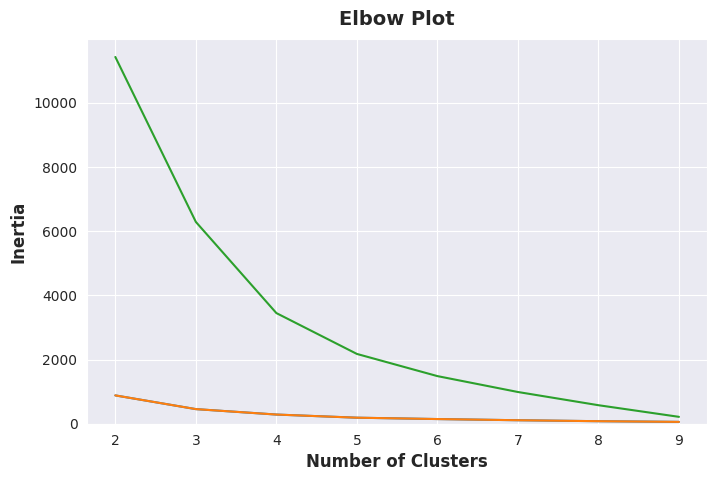

In [57]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
sns.lineplot(x=range_clusters_2, y=inertias_2)
sns.lineplot(x=range_clusters_3, y=inertias_3)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

In [58]:
def corr_labels_2(elem):
    if elem == 1:
        return 2
    elif elem == 2:
        return 1
    else:
        return elem


labels_2 = pd.Series(labels_2).apply(corr_labels_2)

In [59]:
def corr_labels_3(elem):
    if elem == 1:
        return 0
    elif elem == 0:
        return 1
    else:
        return elem


labels_3 = pd.Series(labels_3).apply(corr_labels_3)

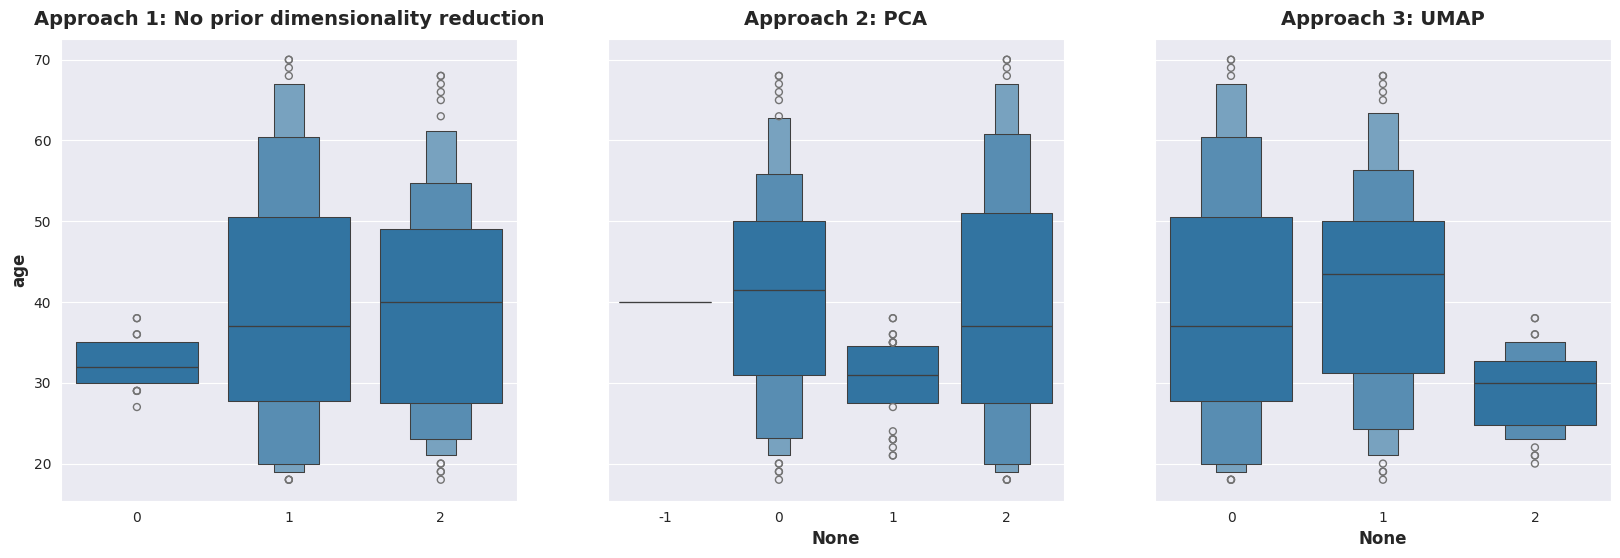

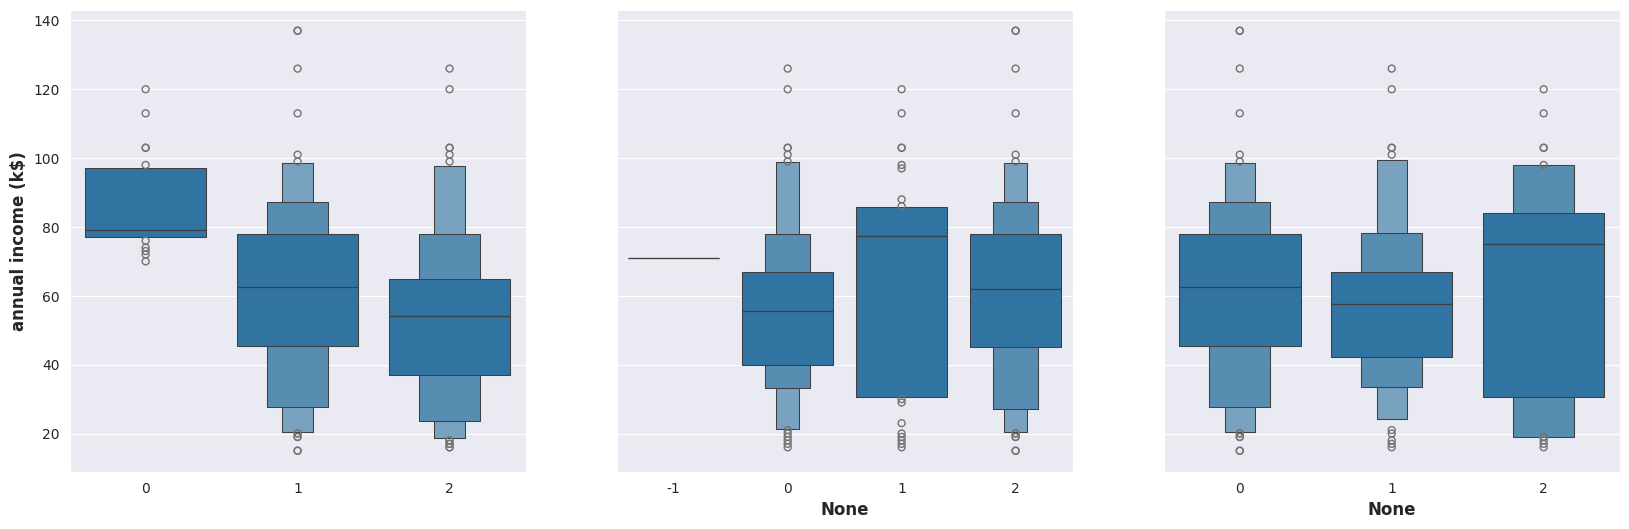

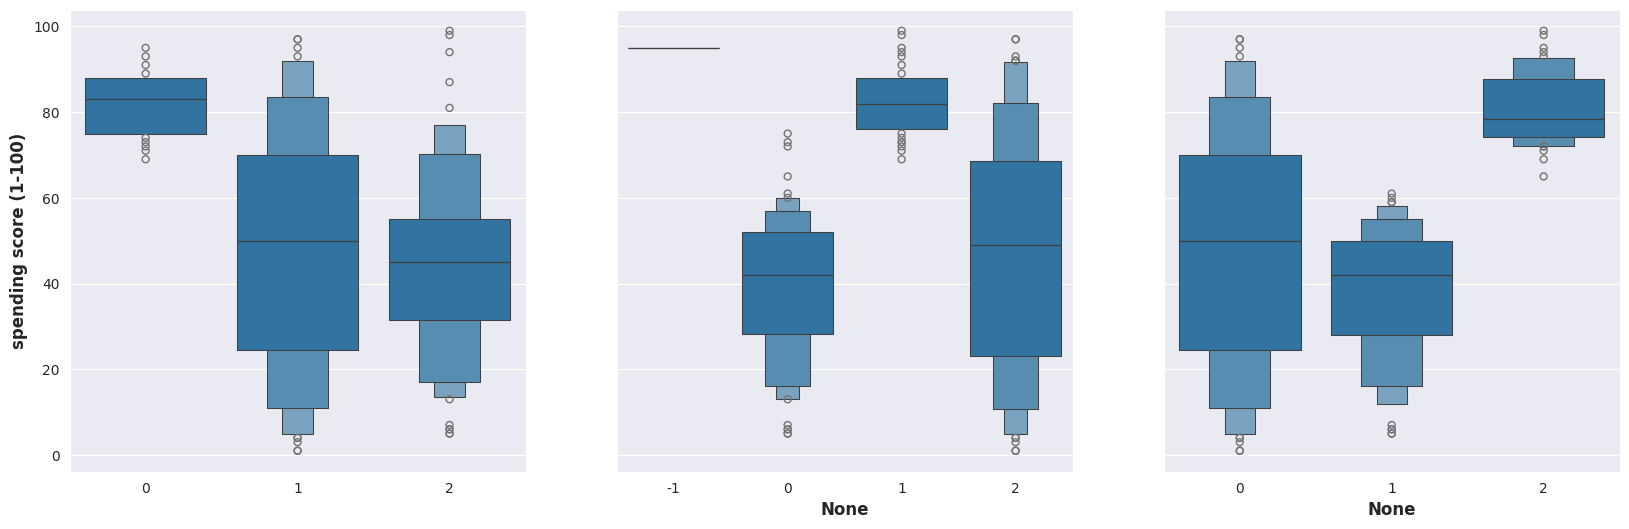

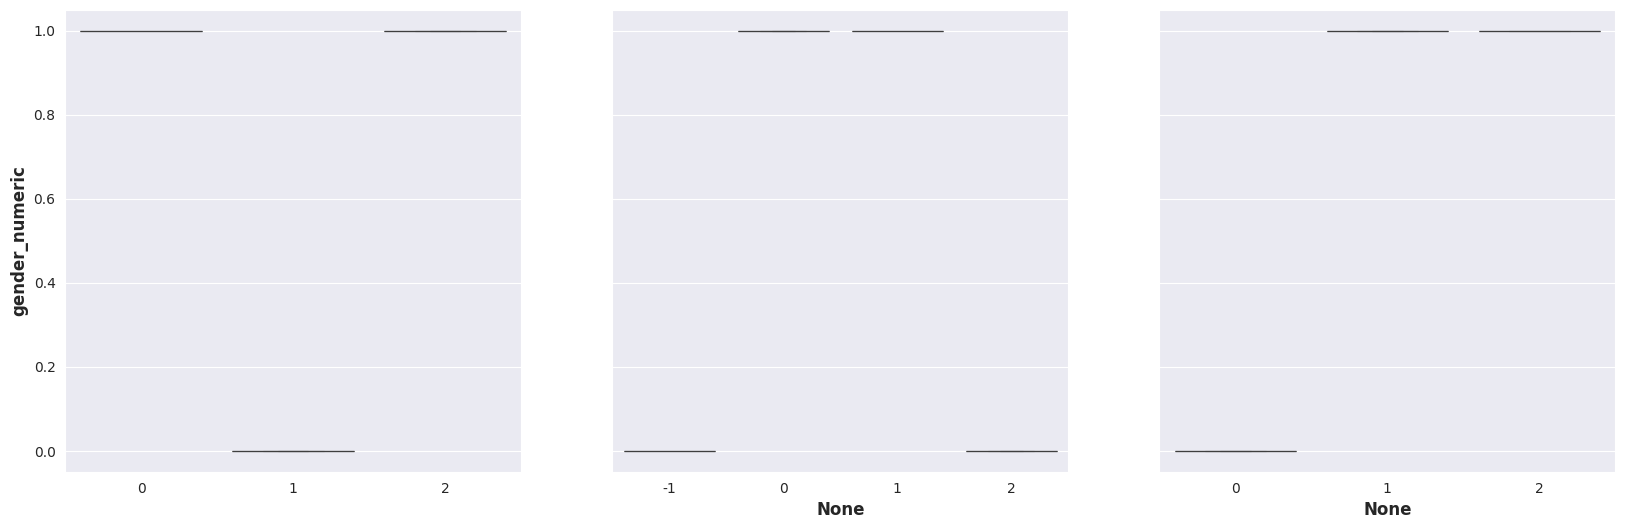

In [60]:
for i, col in enumerate(df.columns):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,6))
    sns.boxenplot(x=labels_1, y=df[col], ax=axs[0])
    sns.boxenplot(x=labels_2, y=df[col], ax=axs[1])
    sns.boxenplot(x=labels_3, y=df[col], ax=axs[2])
    if i == 0:
        axs[0].set_title("Approach 1: No prior dimensionality reduction")
        axs[1].set_title("Approach 2: PCA")
        axs[2].set_title("Approach 3: UMAP")
    plt.show()

In [61]:
counts_1 = pd.Series(labels_1).value_counts().sort_index()
counts_2 = pd.Series(labels_2).value_counts().sort_index()
counts_3 = pd.Series(labels_3).value_counts().sort_index()

cluster_counts = pd.DataFrame({"app_1": counts_1, "app_2": counts_2, "app_3": counts_3})

cluster_counts.index.name = "cluster_id"

cluster_counts

,app_1,app_2,app_3
cluster_id,,,
-1,NaN,1,NaN
0,21.0,82,88.0
1,88.0,30,78.0
2,91.0,87,34.0


In [62]:
df.head()

,age,annual income (k$),spending score (1-100),gender_numeric
0,19,15,39,0
1,21,15,81,0
2,20,16,6,1
3,23,16,77,1
4,31,17,40,1


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define features and target variable
X = df.drop('gender_numeric', axis=1)
y = df['gender_numeric']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the first few rows of the training set
X_train.head(), y_train.head()

# Crear el clasificador de vecinos más cercanos
clf = KNeighborsClassifier(n_neighbors=3)

# Entrenar el clasificador
clf.fit(X_train, y_train)

# Predecir las etiquetas para los datos de prueba
y_pred = clf.predict(X_test)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print('Precisión del clasificador:', accuracy)

Precisión del clasificador: 0.45


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir los precios de las viviendas para los datos de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print('Error cuadrático medio:', mse)

Error cuadrático medio: 0.2483280030588891


In [65]:
print("Número de muestras en el conjunto de entrenamiento:", len(X_train))
print("Número de muestras en el conjunto de prueba:", len(X_test))

Número de muestras en el conjunto de entrenamiento: 160
Número de muestras en el conjunto de prueba: 40


Validación Cruzada:

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Crear un clasificador de regresión logística
clf = LogisticRegression()

# Realizar validación cruzada
scores = cross_val_score(clf, X, y, cv=5)

print("Precisión de validación cruzada:", scores)

Precisión de validación cruzada: [0.55  0.55  0.575 0.55  0.475]


Métricas de Evaluación del Modelo:


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Crear el clasificador de vecinos más cercanos
clf = KNeighborsClassifier(n_neighbors=3)
# Entrenar el clasificador
clf.fit(X_train, y_train)
# Predecir las etiquetas para los datos de prueba
y_pred = clf.predict(X_test)
# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print('Precisión del clasificador:', accuracy)
# Predicciones del modelo
y_pred = clf.predict(X_test)
# Calcular métricas de evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Precisión:", accuracy)
print("Precisión promedio ponderada:", precision)
print("Recall promedio ponderado:", recall)
print("F1-score promedio ponderado:", f1)

Precisión del clasificador: 0.45
Precisión: 0.45
Precisión promedio ponderada: 0.4466751918158568
Recall promedio ponderado: 0.45
F1-score promedio ponderado: 0.44722222222222224


In [68]:
from sklearn.tree import DecisionTreeClassifier

# Crear un clasificador de árbol de decisión
clf = DecisionTreeClassifier()

# Entrenar el clasificador
clf.fit(X_train, y_train)

# Evaluar el rendimiento del clasificador
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de árbol de decisión:", accuracy)

Precisión del clasificador de árbol de decisión: 0.5


Ajuste de parámetros de un árbol de decisión:


In [69]:
# Crear un clasificador de árbol de decisión con parámetros personalizados
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=42)

# Entrenar el clasificador con los parámetros personalizados
clf.fit(X_train, y_train)

# Evaluar el rendimiento del clasificador con los parámetros personalizados
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de árbol de decisión (con parámetros personalizados):", accuracy)


Precisión del clasificador de árbol de decisión (con parámetros personalizados): 0.675


Visualización del árbol de decisión:


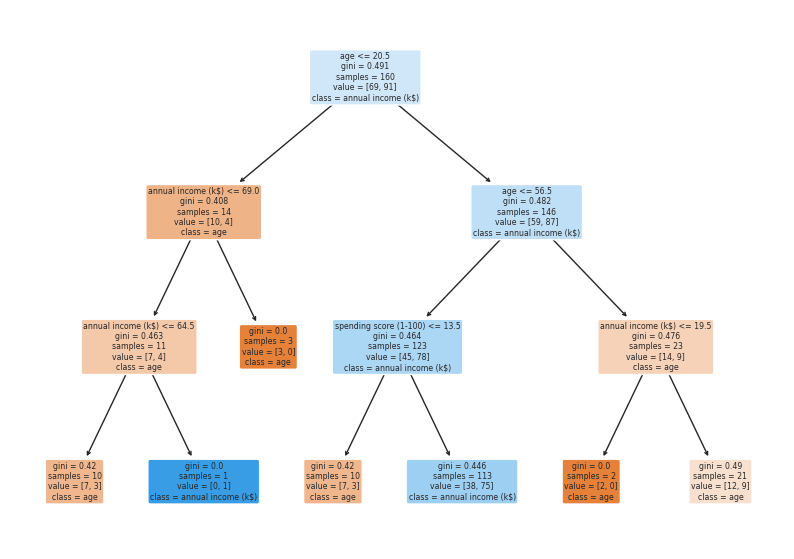

In [70]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualizar el árbol de decisión
plt.figure(figsize=(10, 7))
plot_tree(clf, feature_names=X.columns, class_names=X.columns, filled=True, rounded=True)
plt.show()

Comparación entre diferentes algoritmos de árboles de decisión:

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Crear clasificadores con diferentes algoritmos de árboles de decisión
clf_id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_c45 = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_cart = DecisionTreeClassifier(criterion='gini', random_state=42)

# Evaluar los clasificadores utilizando validación cruzada
scores_id3 = cross_val_score(clf_id3, X, y, cv=5)
scores_c45 = cross_val_score(clf_c45, X, y, cv=5)
scores_cart = cross_val_score(clf_cart, X, y, cv=5)

# Imprimir los resultados de la validación cruzada
print("Precisión media de ID3:", scores_id3.mean())
print("Precisión media de C4.5:", scores_c45.mean())
print("Precisión media de CART:", scores_cart.mean())

Precisión media de ID3: 0.54
Precisión media de C4.5: 0.54
Precisión media de CART: 0.49000000000000005


Implementación básica de bosques aleatorios

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Crear y entrenar un clasificador de Bosques Aleatorios
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el rendimiento del clasificador
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Bosques Aleatorios:", accuracy)

Precisión del clasificador de Bosques Aleatorios: 0.6


In [73]:
#Ajuste de parámetros de Bosques Aleatorios

# Crear y entrenar un clasificador de Bosques Aleatorios con parámetros personalizados
clf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, random_state=42)
clf.fit(X_train, y_train)

# Evaluar el rendimiento del clasificador con los parámetros personalizados
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Bosques Aleatorios (con parámetros personalizados):", accuracy)


Precisión del clasificador de Bosques Aleatorios (con parámetros personalizados): 0.65


Comparación con árboles de decisión tradicionales


In [74]:
from sklearn.tree import DecisionTreeClassifier

# Crear y entrenar un clasificador de árbol de decisión
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Evaluar el rendimiento del clasificador de árbol de decisión
y_pred_dt = dt_clf.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Precisión del clasificador de árbol de decisión:", accuracy_dt)

Precisión del clasificador de árbol de decisión: 0.525


Implementación de Validación Cruzada

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# Inicialización del modelo
clf = DecisionTreeClassifier()

# Validación cruzada con 5 folds
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy:", scores.mean())

Accuracy: 0.525


Curvas de Aprendizaje

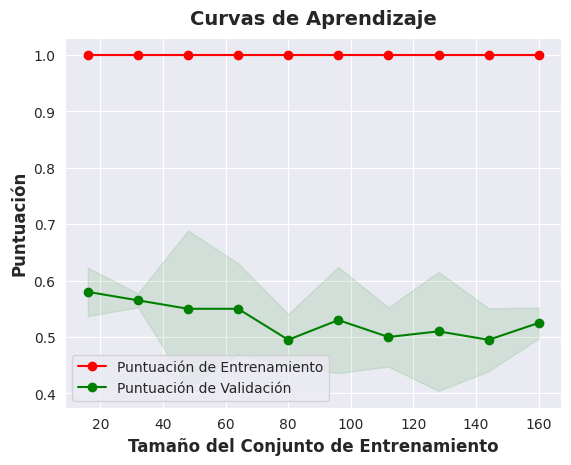

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification

# Inicialización del modelo
clf = DecisionTreeClassifier()

# Cálculo de las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
	clf, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

# Visualización de las curvas de aprendizaje
plt.figure()
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Puntuación")
plt.grid(True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
             	train_scores_mean + train_scores_std, alpha=0.1,
             	color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
             	test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
     	label="Puntuación de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
     	label="Puntuación de Validación")

plt.legend(loc="best")
plt.show()

Interpretación de Métricas de Evaluación

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicialización del modelo
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predicciones sobre el conjunto de prueba
y_pred = clf.predict(X_test)

# Cálculo de métricas de evaluación
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precisión:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precisión: 0.5652173913043478
Recall: 0.6190476190476191
F1-score: 0.5909090909090909


In [80]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_moons

# Graficando
#plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")# When the label y is 0
#plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")# When the label y is 1
plt.show()

# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Inicialización del modelo
model = RandomForestClassifier()
# Entrenamiento del modelo
model.fit(X_train, y_train)
# Evaluación del modelo
accuracy = model.score(X_test, y_test)
print("Exactitud del modelo:", accuracy)

# Ajuste de hiperparámetros con búsqueda de cuadrícula
param_grid = {'n_estimators': [10, 20, 30],
          	'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
# Mejor configuración de hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
# Evaluación del modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Exactitud del modelo con los mejores hiperparámetros:", accuracy)

Exactitud del modelo: 0.6
Mejores hiperparámetros: {'max_depth': 20, 'n_estimators': 20}
Exactitud del modelo con los mejores hiperparámetros: 0.575


# Regresion

La correlación entre la edad y los ingresos anuales es de: -0.012398042736060145


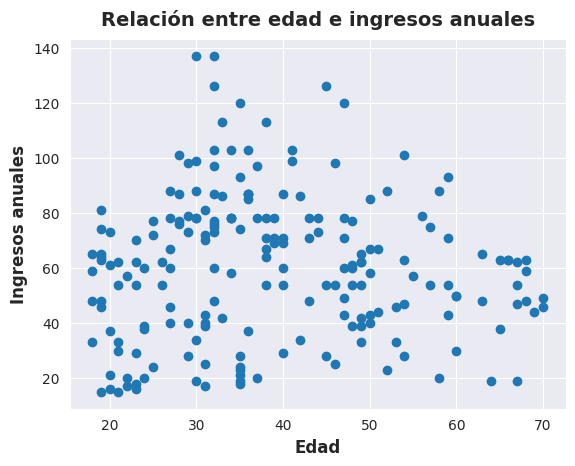

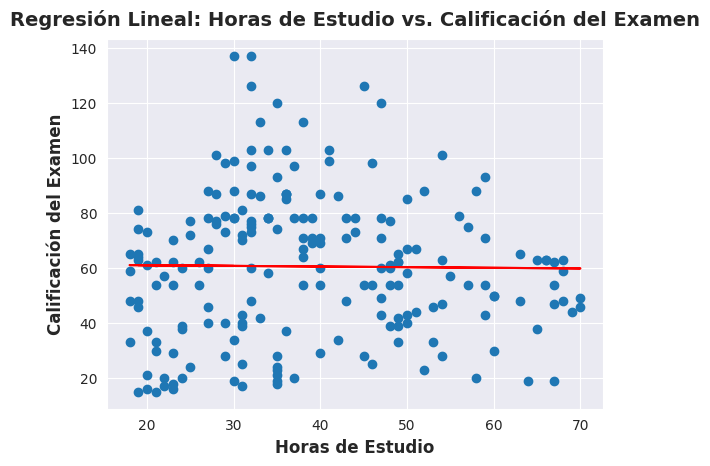

In [94]:
def calcular_correlacion(x, y):
    correlacion = np.corrcoef(x, y)[0, 1]
    return correlacion
correlacion = calcular_correlacion(df['age'], df['annual income (k$)'])
print("La correlación entre la edad y los ingresos anuales es de:", correlacion)

plt.scatter(df['age'], df['annual income (k$)'])
plt.xlabel('Edad')
plt.ylabel('Ingresos anuales')
plt.title('Relación entre edad e ingresos anuales')
plt.show()

from sklearn.linear_model import LinearRegression
modelo_regresion = LinearRegression()
modelo_regresion.fit(np.array(df['age']).reshape(-1, 1), df['annual income (k$)'])
plt.scatter(df['age'], df['annual income (k$)'])
plt.plot(df['age'], modelo_regresion.predict(np.array(df['age']).reshape(-1, 1)), color='red')
plt.xlabel('Horas de Estudio')
plt.ylabel('Calificación del Examen')
plt.title('Regresión Lineal: Horas de Estudio vs. Calificación del Examen')
plt.show()

Método de Mínimos Cuadrados:

In [98]:
print("Error cuadrático medio:", mse)

Error cuadrático medio: 0.2483280030588891


# Máquinas de Soporte Vectorial (SVM)

Clasificación con SVM utilizando scikit-learn

In [107]:
from sklearn.svm import SVC

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo SVM para clasificación
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de prueba
y_pred = svm_classifier.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo SVM para clasificación:", accuracy)

Precisión del modelo SVM para clasificación: 0.525


Accuracy: 0.525


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


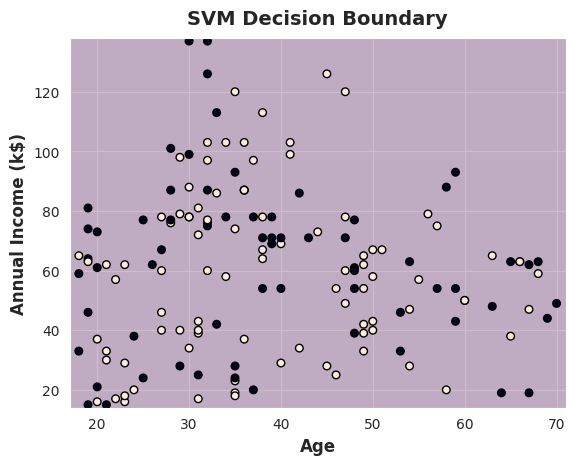

In [112]:
# Crear y entrenar el modelo SVM
svm_classifier = SVC(kernel='linear', random_state=0)
svm_classifier.fit(X_train, y_train)

# Hacer predicciones
y_pred = svm_classifier.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Visualizar los datos y la decisión del SVM
x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

#  Need to include the third feature for prediction.
# Assuming the third feature is in the third column (index 2) of X_train
# Adjust the index if it's different

third_feature = X_train.iloc[:, 2].mean()  #  Using the mean value for simplicity. You might need a more sophisticated approach.
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, third_feature)])

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, s=30, edgecolor='k')
plt.title('SVM Decision Boundary')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.show()

In [113]:
# Crear y entrenar modelos SVM con diferentes kernels
svm_classifier_rbf = SVC(kernel='rbf')
svm_classifier_poly = SVC(kernel='poly')
svm_classifier_rbf.fit(X_train, y_train)
svm_classifier_poly.fit(X_train, y_train)

# Predecir etiquetas para el conjunto de prueba
y_pred_rbf = svm_classifier_rbf.predict(X_test)
y_pred_poly = svm_classifier_poly.predict(X_test)

# Calcular la precisión de los modelos
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
accuracy_poly = accuracy_score(y_test, y_pred_poly)

print("Precisión del modelo SVM con kernel RBF:", accuracy_rbf)
print("Precisión del modelo SVM con kernel Polinomial:", accuracy_poly)

Precisión del modelo SVM con kernel RBF: 0.6
Precisión del modelo SVM con kernel Polinomial: 0.6


SVM para regresión:

(200, 1)
(200,)
Error cuadrático medio del modelo SVM para regresión: 0.38999999999951207


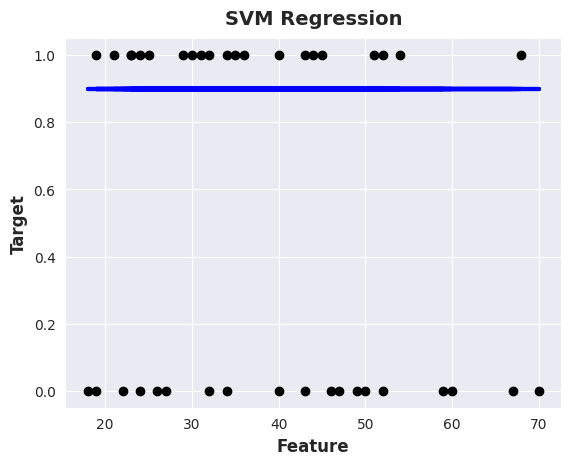

In [120]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Seleccionar solo una característica de 'X' para que coincida con n_features=1
X_regression = X.iloc[:, [0]].values  # Selecciona la primera columna de 'X' y conviértela a matriz NumPy

# Asegurarse de que 'y' sea una matriz NumPy
y_regression = y.values

# Opcional: Asegurarse de que 'y' es de una sola dimensión, aunque esto ya suele ser el caso
y_regression = y_regression.reshape(-1,)

# Ahora 'X_one_feature' y 'y_numeric' son similares a los datos generados por 'make_regression'
print(X_regression.shape)  # Debería imprimir (n_samples, 1)
print(y_regression.shape)      # Debería imprimir (n_samples,)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Crear y entrenar un modelo SVM para regresión
svm_regressor = SVR(kernel='linear')
svm_regressor.fit(X_train, y_train)

# Predecir valores para el conjunto de prueba
y_pred = svm_regressor.predict(X_test)
# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio del modelo SVM para regresión:", mse)

# Visualizar resultados
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('SVM Regression')
plt.show()

In [118]:
df

,age,annual income (k$),spending score (1-100),gender_numeric
0,19,15,39,0
1,21,15,81,0
2,20,16,6,1
3,23,16,77,1
4,31,17,40,1
...,...,...,...,...
195,35,120,79,1
196,45,126,28,1
197,32,126,74,0
198,32,137,18,0


In [119]:
df['age']

0      19
1      21
2      20
3      23
4      31
       ..
195    35
196    45
197    32
198    32
199    30
Name: age, Length: 200, dtype: int64